In [1]:
import os
import pickle
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor, as_completed
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append(str(Path.cwd().parent))

In [2]:
# Directory containing pickle files
directory = Path("../results/regression_std/quantitative") # NOTE THE FILE PATH!!!

# Optionally filter for specific substrings
pkl_files = [f for f in directory.iterdir() if f.suffix == ".pkl"]

# Efficient loader
def load_file(file_path):
    try:
        with open(file_path, "rb") as f:
            data = pickle.load(f)
            if isinstance(data, dict):
                return file_path.name, data
    except (EOFError, pickle.UnpicklingError) as e:
        print(f"Warning: Failed to load {file_path.name}: {e}")
    except Exception as e:
        print(f"Unexpected error with {file_path.name}: {e}")
    return None

# Load files using multithreading (I/O bound)
all_data = {}
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(load_file, f) for f in pkl_files]
    for future in as_completed(futures):
        result = future.result()
        if result:
            filename, data = result
            all_data[filename] = data

files = list(all_data.keys())


In [3]:
records = []

for file, dictionary in all_data.items():
    records.append(dictionary)

# Create the DataFrame
df = pd.DataFrame(records)

print(df.shape)



(72528, 25)


In [4]:
# Prepare the dataframe
df = df[df['k'] != 1]
df['is_auto'] = pd.Series(df['k'] == 'auto', dtype=bool)
df['is_all'] = pd.Series(df['k'] == 'all', dtype=bool)
df.loc[df['is_all'], 'k'] = df['n_samples']
df.loc[df['k'].isna(), 'k'] = 'NA'
df.loc[df['prox_method'].isna(), 'prox_method'] = 'NA'

In [5]:
df['Method'] = df['method']
df.loc[df['Method'] == 'qrf', 'Method'] = 'QRF'

df.loc[df['Method'] == 'zrf', 'Method'] = 'OOB Int.' # Perhaps change this name

df.loc[(df['Method'] == 'proximity_based') & (df['prox_method'] == 'rfgap'), 'Method'] = 'RF-FIRE'
df.loc[(df['Method'] == 'proximity_based') & (df['prox_method'] == 'original'), 'Method'] = 'RF-FIRE (Original)'
df.loc[(df['Method'] == 'proximity_based') & (df['prox_method'] == 'oob'), 'Method'] = 'RF-FIRE (OOB)'

In [6]:
df.Method

0                       QRF
1                   RF-FIRE
2        RF-FIRE (Original)
3                  OOB Int.
5                  OOB Int.
                ...        
72523         RF-FIRE (OOB)
72524              OOB Int.
72525                   QRF
72526              OOB Int.
72527              OOB Int.
Name: Method, Length: 69929, dtype: object

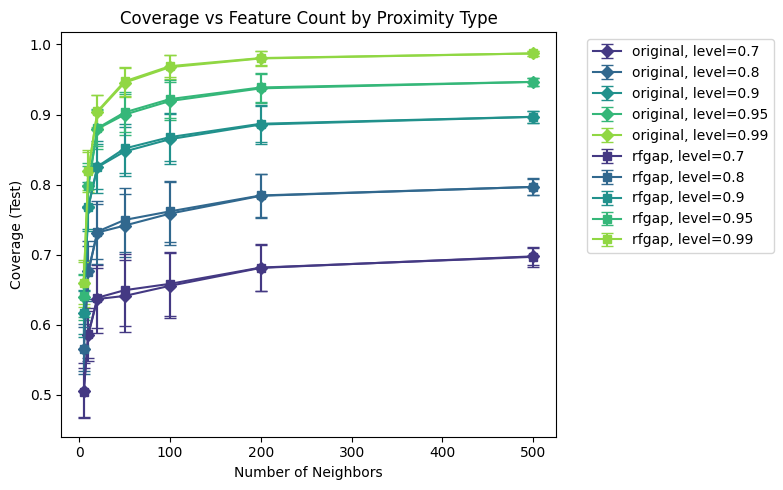

In [7]:
import matplotlib.pyplot as plt



pivot_df = (
    df[
        (df['k'].isin([5, 10, 20, 50, 100, 200, 500])) &
        (df['method'] == 'proximity_based') &
        (df['prox_method'].isin(['rfgap', 'original']))
    ]
    .groupby(['prox_method', 'level', 'k'])['coverage']
    .agg(['mean', 'std'])
    .reset_index()
)

prox_styles = {'oob': 'o', 'rfgap': 's', 'original': 'D'}
levels = sorted(pivot_df['level'].unique())
level_palette = dict(zip(levels, sns.color_palette("viridis", len(levels))))

fig, ax = plt.subplots(figsize=(8, 5))
for prox_method, group in pivot_df.groupby('prox_method'):
    for level, subgrp in group.groupby('level'):
        ax.errorbar(
            subgrp['k'],
            subgrp['mean'],
            yerr=subgrp['std'],
            marker=prox_styles.get(prox_method, 'o'),
            color=level_palette[level],
            label=f"{prox_method}, level={level}",
            linestyle='-',
            capsize=4
        )

ax.set_title('Coverage vs Feature Count by Proximity Type')
ax.set_ylabel('Coverage (Test)')
ax.set_xlabel('Number of Neighbors')
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

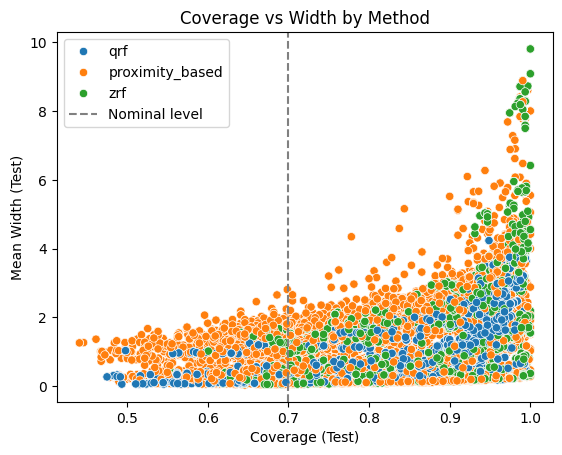

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x='coverage_test', y='width_mean_test', hue='method')
plt.axvline(df['level'].iloc[0], color='gray', linestyle='--', label='Nominal level')
plt.xlabel('Coverage (Test)')
plt.ylabel('Mean Width (Test)')
plt.title('Coverage vs Width by Method')
plt.legend()
plt.show()


/yunity/rhodes8/.local/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


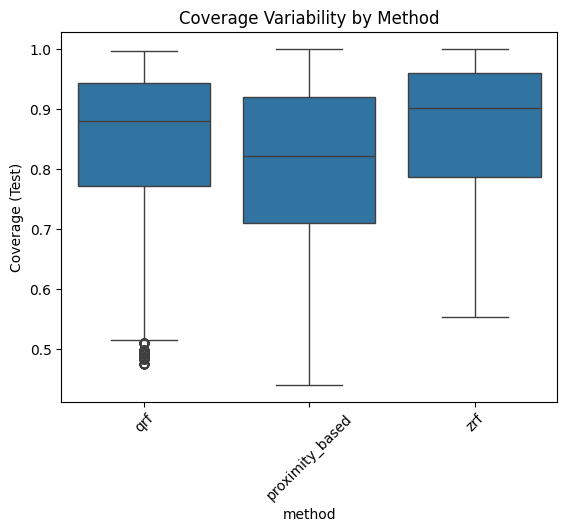

In [9]:
sns.boxplot(data=df, x='method', y='coverage_test')
plt.title('Coverage Variability by Method')
plt.ylabel('Coverage (Test)')
plt.xticks(rotation=45)
plt.show()


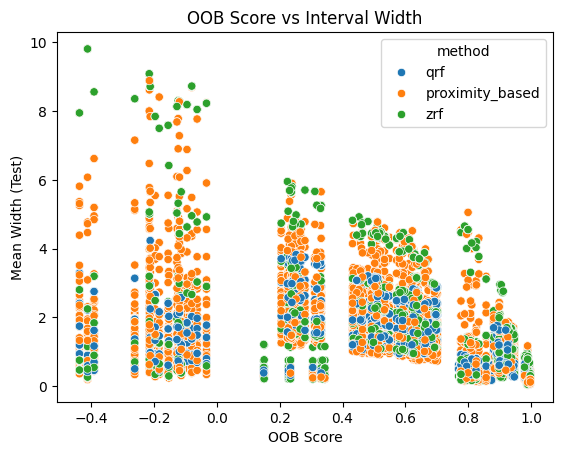

In [10]:
sns.scatterplot(data=df, x='oob_score_', y='width_mean_test', hue='method')
plt.xlabel('OOB Score')
plt.ylabel('Mean Width (Test)')
plt.title('OOB Score vs Interval Width')
plt.show()


/yunity/rhodes8/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/yunity/rhodes8/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/yunity/rhodes8/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


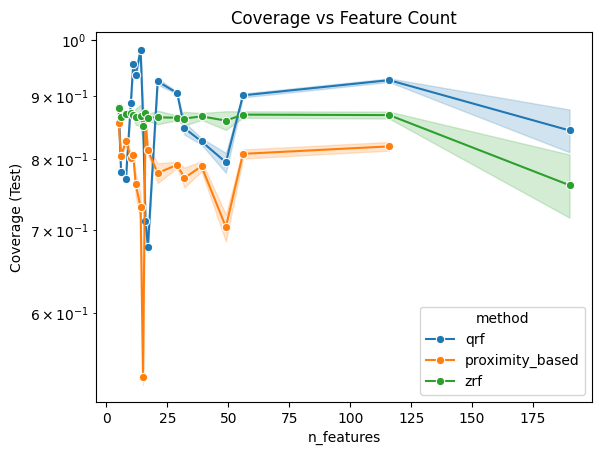

/yunity/rhodes8/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/yunity/rhodes8/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/yunity/rhodes8/.local/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


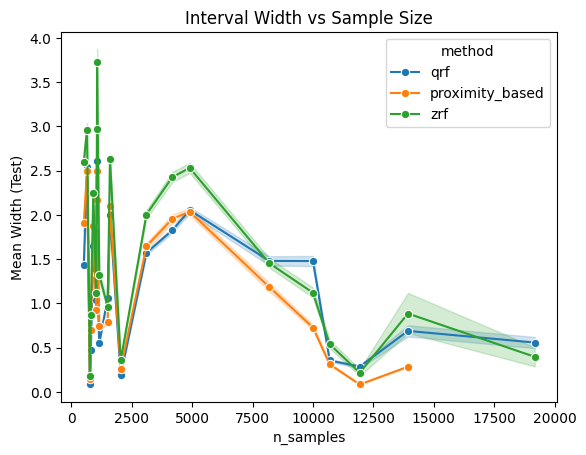

In [11]:
sns.lineplot(data=df, x='n_features', y='coverage_test', hue='method', marker='o')
plt.yscale('log')
plt.title('Coverage vs Feature Count')
plt.ylabel('Coverage (Test)')
plt.show()

sns.lineplot(data=df, x='n_samples', y='width_mean_test', hue='method', marker='o')
plt.title('Interval Width vs Sample Size')
plt.ylabel('Mean Width (Test)')
plt.show()


In [22]:
width_quantiles

,Method,k,width_min,width_q1,width_median,width_q3,width_max
0,QRF,NA,0.000000,0.615668,0.923502,1.323686,4.617509
1,RF-FIRE,auto,0.017333,0.057995,0.217233,0.545672,7.678696
3,OOB Int.,NA,1.271832,1.271832,1.271832,1.271832,1.271832
5,OOB Int.,NA,1.521599,1.521599,1.521599,1.521599,1.521599
7,QRF,NA,0.089056,1.170847,1.665118,2.333446,5.450655
...,...,...,...,...,...,...,...
72522,QRF,NA,0.000000,0.751577,1.084120,1.485338,3.328050
72524,OOB Int.,NA,0.781757,0.781757,0.781757,0.781757,0.781757
72525,QRF,NA,0.000000,0.289363,0.520331,0.773609,2.449616
72526,OOB Int.,NA,0.343941,0.343941,0.343941,0.343941,0.343941


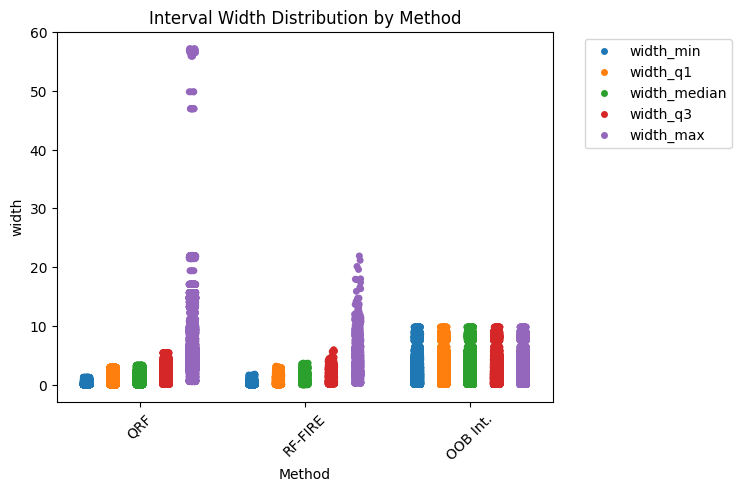

In [24]:
# Keep something like this as well.
# May need to do some grouping by k!!!

# WAS WORKING WITHOUT K
width_quantiles = df[['Method', 'k', 'width_min', 'width_q1', 'width_median', 'width_q3', 'width_max']]
width_quantiles = width_quantiles.loc[width_quantiles['k'].isin(['NA', 'auto'])]

width_quantiles = width_quantiles[['Method', 'width_min', 'width_q1', 'width_median', 'width_q3', 'width_max']]

# width_quantiles = df[['Method', 'width_min_test', 'width_q1_test', 'width_median_test', 'width_q3_test', 'width_max_test']]
width_quantiles = width_quantiles[width_quantiles['Method'].isin(['QRF', 'OOB Int.', 'RF-FIRE'])]
long_df = width_quantiles.melt(id_vars='Method', var_name='quantile', value_name='width')

sns.stripplot(data=long_df, x='Method', y='width', hue='quantile', dodge = True)
# plt.yscale('log')
plt.title('Interval Width Distribution by Method')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


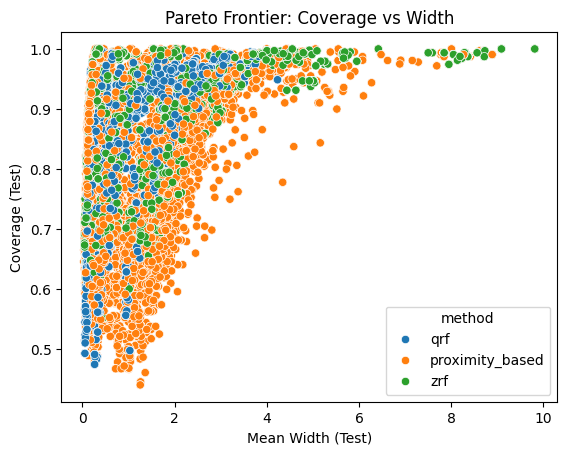

In [13]:
sns.scatterplot(data=df, x='width_mean_test', y='coverage_test', hue='method')
plt.xlabel('Mean Width (Test)')
plt.ylabel('Coverage (Test)')
plt.title('Pareto Frontier: Coverage vs Width')
plt.show()


In [14]:
def balanced_interval_score(width, coverage, target_coverage=0.95, penalty_weight=1.0):
    """
    Compute the Balanced Interval Score (BIS).
    
    Parameters:
    - width: float or array-like, the width(s) of the interval(s)
    - coverage: float or array-like, the empirical coverage rate(s) (e.g., proportion of times true value in interval)
    - target_coverage: float, desired coverage level (e.g., 0.95)
    - penalty_weight: float, how heavily to penalize deviations from target coverage
    
    Returns:
    - BIS value(s): float or array-like
    """
    import numpy as np
    
    width = np.asarray(width)
    coverage = np.asarray(coverage)
    penalty = 1 + penalty_weight * np.abs(coverage - target_coverage)
    bis = 1.0 / (width * penalty)
    
    return bis


In [15]:
widths = df['width_mean']
coverages = df['coverage']
levels = df['level']

In [16]:
df['bis'] = balanced_interval_score(df['width_mean'], df['coverage'], df['level'],
                                    penalty_weight=1)

<Axes: xlabel='Method', ylabel='bis'>

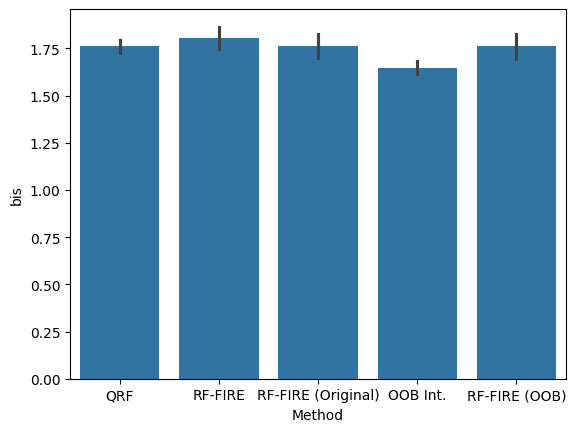

In [17]:
# Keep something like this.
sns.barplot(data=df, x='Method', y='bis')

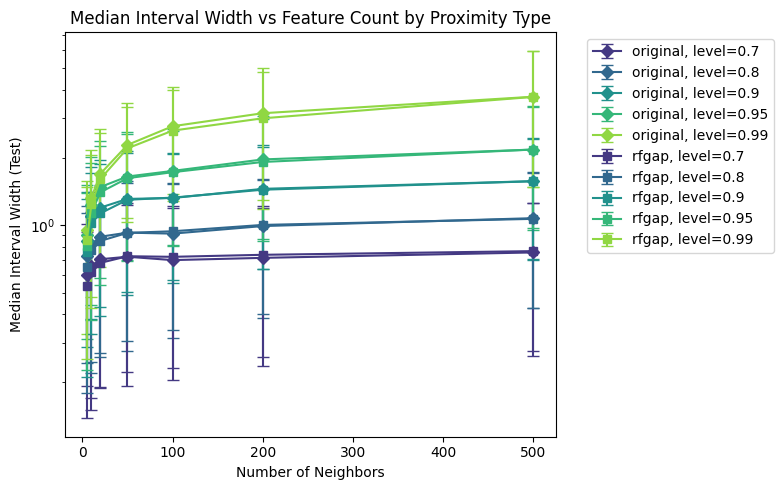

In [18]:
pivot_df = (
    df[
        (df['k'].isin([5, 10, 20, 50, 100, 200, 500])) &
        (df['method'] == 'proximity_based') &
        (df['prox_method'].isin(['rfgap', 'original']))
    ]
    .groupby(['prox_method', 'level', 'k'])['width_median_test']
    .agg(['mean', 'std'])
    .reset_index()
)

prox_styles = {'oob': 'o', 'rfgap': 's', 'original': 'D'}
levels = sorted(pivot_df['level'].unique())
level_palette = dict(zip(levels, sns.color_palette("viridis", len(levels))))

fig, ax = plt.subplots(figsize=(8, 5))
for prox_method, group in pivot_df.groupby('prox_method'):
    for level, subgrp in group.groupby('level'):
        ax.errorbar(
            subgrp['k'],
            subgrp['mean'],
            yerr=subgrp['std'],
            marker=prox_styles.get(prox_method, 'o'),
            color=level_palette[level],
            label=f"{prox_method}, level={level}",
            linestyle='-',
            capsize=4
        )

ax.set_title('Median Interval Width vs Feature Count by Proximity Type')
ax.set_ylabel('Median Interval Width (Test)')
ax.set_xlabel('Number of Neighbors')

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_yscale('log')
fig.tight_layout()
plt.show()


In [19]:
df

,method,prox_method,level,random_state,oob_score_,k,coverage_test,coverage,width_mean_test,width_std_test,...,width_median,width_q3,width_max,name,n_features,n_samples,is_auto,is_all,Method,bis
0,qrf,NA,0.70,110269,0.521897,NA,0.782297,0.740335,1.136727,7.005123e-01,...,0.923502,1.323686,4.617509,abalone,10,4177,False,False,QRF,0.906892
1,proximity_based,rfgap,0.95,671156,0.811257,auto,0.867435,0.789864,0.601979,9.912228e-01,...,0.217233,0.545672,7.678696,socmob,39,1156,True,False,RF-FIRE,1.572380
2,proximity_based,original,0.90,131933,0.330007,500,0.861538,0.898678,2.393431,5.508249e-16,...,2.393431,2.393431,2.393431,student_performance_por,56,649,False,False,RF-FIRE (Original),0.417259
3,zrf,rfgap,0.70,131933,0.502441,NA,0.702721,0.699825,1.271832,2.877677e-16,...,1.271832,1.271832,1.271832,white_wine,11,4898,False,False,OOB Int.,0.786130
5,zrf,rfgap,0.80,131933,0.533623,NA,0.797448,0.800205,1.521599,1.471863e-16,...,1.521599,1.521599,1.521599,abalone,10,4177,False,False,OOB Int.,0.657069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72523,proximity_based,oob,0.70,131933,0.919473,auto,0.707317,0.614068,0.461307,2.094641e-01,...,0.374883,0.521696,1.878427,airfoil_self_noise,5,1503,True,False,RF-FIRE (OOB),2.167859
72524,zrf,rfgap,0.99,671156,0.988975,NA,0.991843,0.988811,0.781757,1.915629e-16,...,0.781757,0.781757,0.781757,auction_verification,16,2043,False,False,OOB Int.,1.277650
72525,qrf,NA,0.70,137338,0.898447,NA,0.734628,0.662968,0.606710,4.106531e-01,...,0.520331,0.773609,2.449616,concrete_compressive_strength,8,1030,False,False,QRF,1.676165
72526,zrf,oob,0.80,259179,0.776918,NA,0.783862,0.799753,0.343941,8.242258e-17,...,0.343941,0.343941,0.343941,socmob,39,1156,False,False,OOB Int.,2.906761
